In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

- https://www.youtube.com/watch?v=ElmBrKyMXxs
- https://github.com/hans/ipython-notebooks/blob/master/tf/TF%20tutorial.ipynb
- https://github.com/ematvey/tensorflow-seq2seq-tutorials

In [2]:
from __future__ import division
import tensorflow as tf
from os import path, remove
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import StratifiedShuffleSplit
from time import time
from matplotlib import pyplot as plt
import seaborn as sns
from mylibs.jupyter_notebook_helper import show_graph, renderStatsList, renderStatsCollection, \
    renderStatsListWithLabels, renderStatsCollectionOfCrossValids
from tensorflow.contrib import rnn
from tensorflow.contrib import learn
import shutil
from tensorflow.contrib.learn.python.learn import learn_runner
from mylibs.tf_helper import getDefaultGPUconfig
from sklearn.metrics import r2_score
from mylibs.py_helper import factors
from fastdtw import fastdtw
from collections import OrderedDict
from scipy.spatial.distance import euclidean
from statsmodels.tsa.stattools import coint
from common import get_or_run_nn
from data_providers.price_history_seq2seq_data_provider import PriceHistorySeq2SeqDataProvider
from models.model_16_price_history_seq2seq_cv import PriceHistorySeq2SeqCV
from data_providers.price_history_dataset_generator import PriceHistoryDatasetGenerator
from skopt.space.space import Integer, Real
from skopt import gp_minimize
from skopt.plots import plot_convergence
import pickle
import inspect
import dill
from os.path import isdir

/home/studenthp/anaconda2/envs/dis/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
dtype = tf.float32
seed = 16011984
random_state = np.random.RandomState(seed=seed)
config = getDefaultGPUconfig()
n_jobs = 1
%matplotlib inline

### Step 0 - hyperparams

vocab_size is all the potential words you could have (classification for translation case)
and max sequence length are the SAME thing

decoder RNN hidden units are usually same size as encoder RNN hidden units in translation but for our case it does not seem really to be a relationship there but we can experiment and find out later, not a priority thing right now

In [4]:
epochs = 15

num_features = 1
num_units = 200 #state size

input_len = 60
target_len = 30

batch_size = 256 #47
#trunc_backprop_len = ??

In [5]:
total_train_size = 57994
#train_len = 57980

train_size = 6400 
test_size = 1282

In [6]:
data_folder = '../../../../Dropbox/data'
assert isdir(data_folder)

### Once generate data

In [7]:
data_path = data_folder + '/price_history'
assert isdir(data_path)

In [8]:
#csv_in = '../price_history_03_seq_start_suddens_trimmed.csv'

In [9]:
npz_full_train = data_path + '/price_history_03_dp_60to30_train.npz'
#npz_train = data_path + '/price_history_03_dp_60to30_57980_train.npz'
npz_train = data_path + '/price_history_03_dp_60to30_6400_train.npz'
npz_test = data_path + '/price_history_03_dp_60to30_test.npz'

In [10]:
# PriceHistorySeq2SeqDataProvider.create_subsampled(outpath=npz_train, target_size=train_size,
#                                                   random_state=random_state,
#     inpath=data_path + '/price_history_03_dp_60to30_train.npz')

In [11]:
# %%time
# train_sku_ids, train_XX, train_YY, train_sequence_lens, train_seq_mask, test_pack = \
# PriceHistoryDatasetGenerator(random_state=random_state).\
#     createAndSaveDataset(
#         csv_in=csv_in,
#         input_seq_len=input_len,
#         target_seq_len=target_len,
#         allowSmallerSequencesThanWindow=False,
#         #min_date = '2016-11-01',
#         split_fraction = 0.40,
#         #keep_training_fraction = 0.22, #57994 * 0.22 = 12758.68
        
#         #disable training for now since we have already created them
#         #save_files_dic = {"train": npz_train, "test": npz_test,}
# )

In [12]:
# print train_sku_ids.shape, train_XX.shape, train_YY.shape, train_sequence_lens.shape, train_seq_mask.shape
# aa,bb,cc,dd,ee = test_pack.get_data()
# aa.shape,bb.shape,cc.shape,dd.shape,ee.shape

### Step 1 - collect data

In [13]:
dp = PriceHistorySeq2SeqDataProvider(npz_path=npz_train, batch_size=batch_size, with_EOS=False)
dp.inputs.shape, dp.targets.shape

((6400, 60, 1), (6400, 30))

In [14]:
aa, bb = dp.next()
aa.shape, bb.shape

((256, 60, 1), (256, 30))

### Step 2 - Build model

In [15]:
model = PriceHistorySeq2SeqCV(rng=random_state, dtype=dtype, config=config, with_EOS=False)

In [16]:
graph = model.getGraph(batch_size=batch_size,
                       num_units=num_units,
                       input_len=input_len,
                       target_len=target_len)

60
Tensor("inputs/unstack:0", shape=(256, 1), dtype=float32)

Tensor("encoder_rnn_layer/rnn/gru_cell_59/add:0", shape=(256, 200), dtype=float32)


Tensor("decoder_rnn_layer/decoder_out_tensor/decoder_out_tensor:0", shape=(?, 256, 200), dtype=float32)

Tensor("readout_layer/readouts:0", shape=(?, 1), dtype=float32)

Tensor("predictions/Reshape:0", shape=(30, 256), dtype=float32)
Tensor("predictions/transpose:0", shape=(256, 30), dtype=float32)

Tensor("error/Select:0", shape=(256, 30), dtype=float32)

Tensor("error/Mean:0", shape=(), dtype=float32)



In [17]:
show_graph(graph)

### Step 3 training the network

RECALL: baseline is around 4 for huber loss for current problem, anything above 4 should be considered as major errors

In [18]:
#rnn_cell = PriceHistorySeq2SeqCV.RNN_CELLS.GRU
#cross_val_n_splits = 5
epochs, num_units, batch_size

(15, 200, 256)

In [19]:
#set(factors(train_size)).intersection(factors(train_size/5))

In [20]:
def run_cv():
    return model.get_cross_validation_score(
        npz_path=npz_train,
        epochs=epochs,
        batch_size=batch_size,
        num_units=num_units,
        input_len = input_len,
        target_len = target_len,
        n_splits=cross_val_n_splits,
    )

In [21]:
#cv_score, stats_list = run_cv()

In [22]:
# _ = renderStatsList(stats_list=stats_list, epochs=epochs, title='Validation Error', kk='error(valid)')
# plt.show()

### Cross Validating to find the best learning rate

In [23]:
model = PriceHistorySeq2SeqCV(rng=random_state, dtype=dtype, config=config, with_EOS=False)

In [24]:
bayes_opt_dir = data_folder + '/bayes_opt'

In [25]:
plotting = True

In [26]:
def gpOptimization(n_calls, n_jobs=n_jobs, n_random_starts=5, verbose=True, filepath = None,
                  cross_val_n_splits = 5):
    if path.isfile(filepath):
        remove(filepath) #delete previously saved file
    
    def objective(params): # Here we define the metric we want to minimise    
        (learning_rate,) = params
        print "params: {}".format(params)

        cv_score, stats_list = model.get_cross_validation_score(
            npz_path=npz_train,
            epochs=epochs,
            batch_size=batch_size,
            num_units=num_units,
            input_len = input_len,
            target_len = target_len,
            n_splits=cross_val_n_splits,
            learning_rate = learning_rate,
        )

        #save everytime in case it crashes
        if filepath is not None:
            stats_dic = np.load(filepath)[()] if path.isfile(filepath) else dict()
            stats_dic[(learning_rate,)] = stats_list
            np.save(filepath, stats_dic)

        if plotting:
            label_text = 'learning rate = {}'.format(learning_rate)
            _ = renderStatsListWithLabels(stats_list=stats_list, label_text=label_text)
            plt.show()

            _ = renderStatsListWithLabels(stats_list=stats_list, label_text=label_text,
                                          title='Validation Error', kk='error(valid)')
            plt.show()

        return cv_score #minimize validation error
    
    learning_rate_space = Real(1e-5, 1e-1, prior='log-uniform')  #uniform or log-uniform
    space  = [learning_rate_space]
    
    return gp_minimize(
        func=objective, # function that we wish to minimise
        dimensions=space, #the search space for the hyper-parameters
        #x0=x0, #inital values for the hyper-parameters
        n_calls=n_calls, #number of times the function will be evaluated
        random_state=random_state, #random seed
        n_random_starts=n_random_starts,#before we start modelling the optimised function with a GP Regression
                            #model, we want to try a few random choices for the hyper-parameters.
        kappa=1.9, #trade-off between exploration vs. exploitation.
        n_jobs=n_jobs
    )

In [27]:
res_gp_filepath = bayes_opt_dir + '/bayes_opt_learning_rate_res_gp.pickle'

In [28]:
if not path.isfile(res_gp_filepath):
    res_gp = gpOptimization(n_calls=15, n_random_starts=5, cross_val_n_splits = 5,
                            filepath=bayes_opt_dir + '/bayes_opt_learning_rate_stats_dic.npy')

In [29]:
#recall that you need to load the 'dill' python module which overrides pickle to be able and pickle res_gp
#https://stackoverflow.com/questions/30943825/pickle-picklingerror-cant-pickle-function-preprocessor-at-0x109217488-its
if path.isfile(res_gp_filepath):
    with open(res_gp_filepath) as fp:  # Python 3: open(..., 'rb')
        res_gp = pickle.load(fp)
else:
    with open(res_gp_filepath, 'w') as fp:  # Python 3: open(..., 'wb')
        pickle.dump(res_gp, fp)

In [30]:
best_params = res_gp.x
best_params

[0.0026945952539362472]

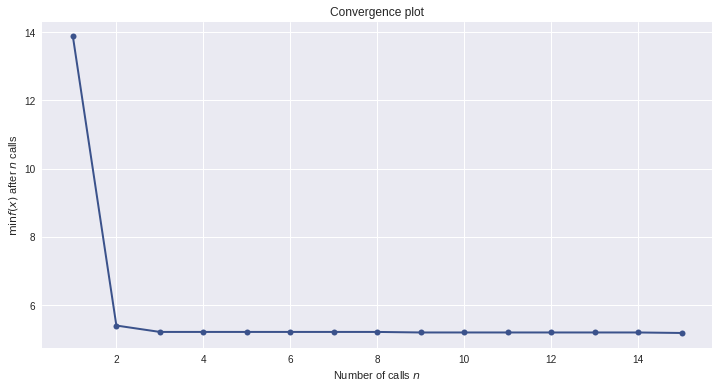

In [31]:
if plotting:
    fig = plt.figure(figsize=(12,6))
    plot_convergence(res_gp)
    plt.grid()
    plt.show()

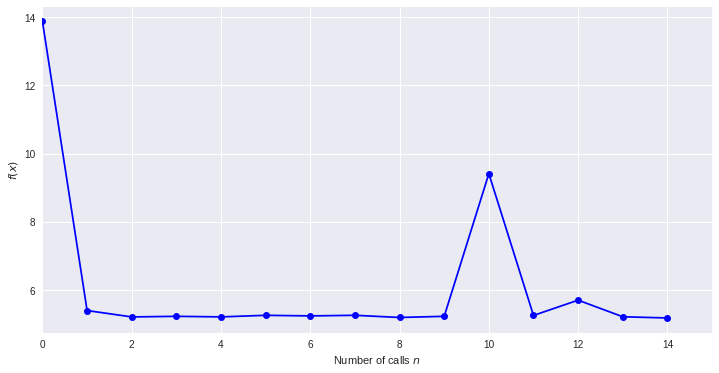

In [32]:
if plotting:
    fig = plt.figure(figsize=(12,6))
    plt.plot(res_gp.func_vals, 'bo-') #'b = blue, o = draw circles, - = draw lines between dots
    #plt.hold(True)
    #plt.scatter(range(len(res_gp.func_vals)), res_gp.func_vals)
    plt.ylabel(r'$f(x)$')
    plt.xlabel('Number of calls $n$')
    plt.xlim([0, len(res_gp.func_vals)])
    plt.show()

In [33]:
filepath=bayes_opt_dir + '/bayes_opt_learning_rate_stats_dic.npy'

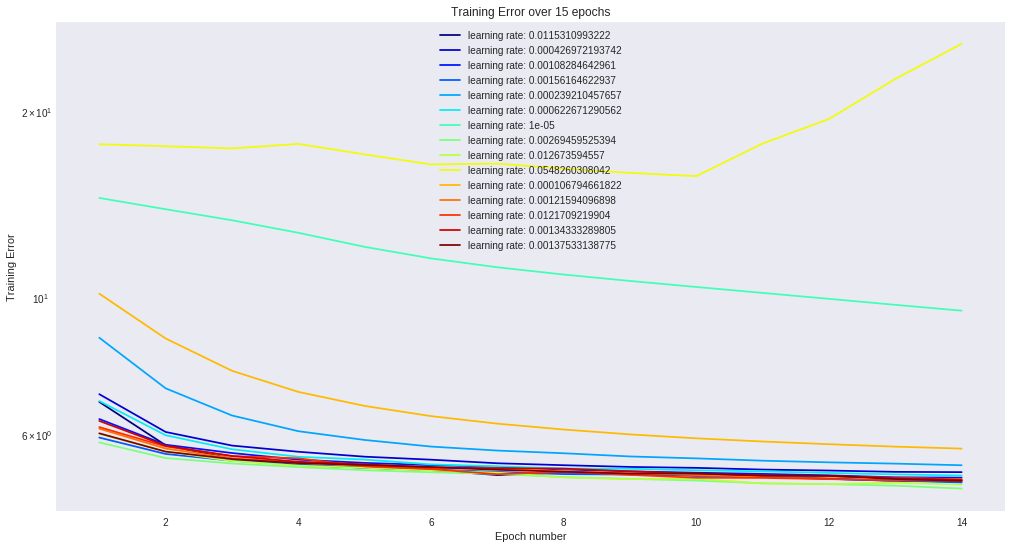

In [38]:
fig = renderStatsCollectionOfCrossValids(stats_dic=np.load(filepath)[()], label_texts=['learning rate'],
                                          with_individual_folds=False)
fig.set_figwidth(17)
fig.set_figheight(9)
plt.yscale('log')
plt.show()

## Full training the entire dataset

#### Performance Notes batch size 223 and train size 57980
We need around 22 seconds / epoch for a split of 5

So let's do some rough calculations

In order to have a good estimate we need let's say 20 epochs

So 20 epochs * 22 seconds * 5 splits = 2200 seconds ~= >36 mins to generate a single CV score!

And we need around 15 runs of bayesian optimization to optimize which means 2200 secs * 15 skopt runs = 33000 secs

Which is equivalent to >9 hours !!  <-- At least this is feasible at a very last run but not while experimenting

So to go from 33000 secs to 900 we would need to increase speed by a factor 36 !

If we would keep only 1/36 of our training dataset to speed up things we would be left with ~1610 samples which is too small for training.

#### Performance Notes batch size 256 and train size 6400
Training time increased a lot but also training (and validation) error have increased as well as it was expected

So I guess the idea here is that we could work with this smaller (and randomly subsampled) training set to find out the best params and then we can return to train the model with the entire dataset before final testing

In [34]:
best_learning_rate = best_params[0]
best_learning_rate

0.0026945952539362472

In [39]:
sorted(factors(train_size))

[1,
 2,
 4,
 5,
 8,
 10,
 16,
 20,
 25,
 32,
 40,
 50,
 64,
 80,
 100,
 128,
 160,
 200,
 256,
 320,
 400,
 640,
 800,
 1280,
 1600,
 3200,
 6400]

In [35]:
factors(total_train_size)

[1, 2, 28997, 57994, 107, 271, 214, 542]

In [36]:
def experiment():
    return model.run(npz_path=npz_full_train,
             epochs=30,
             batch_size = 107,
             num_units = 300,
             input_len=input_len,
             target_len=target_len,
             learning_rate = best_learning_rate,
             preds_gather_enabled=True)

In [37]:
%%time
dyn_stats, preds_dict = get_or_run_nn(
    experiment,
    filename='016_seq2seq_60to30_30epochs_num_units300_epochs30_learning_rate{:.4f}'.format(
        best_learning_rate
    )
)

learning rate: 0.002695
epochs: 30
num units: 300


KeyboardInterrupt: 

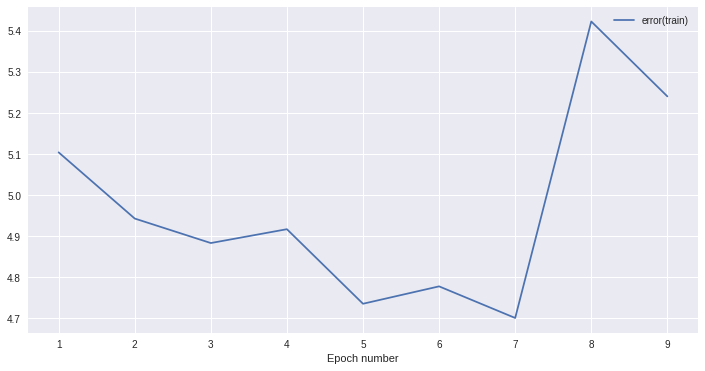

In [40]:
dyn_stats.plotStats()
plt.show()

In [41]:
r2_scores = [r2_score(y_true=dp.targets[ind], y_pred=preds_dict[ind])
            for ind in range(len(dp.targets))]

In [44]:
ind = np.argmin(r2_scores)
ind

2893

In [45]:
reals = dp.targets[ind]
preds = preds_dict[ind]

In [46]:
r2_score(y_true=reals, y_pred=preds)

-1.9076913927262015e+33

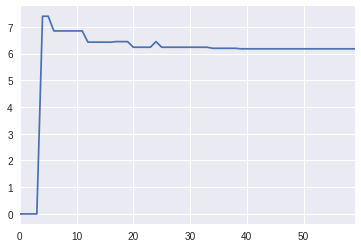

In [47]:
sns.tsplot(data=dp.inputs[ind].flatten())

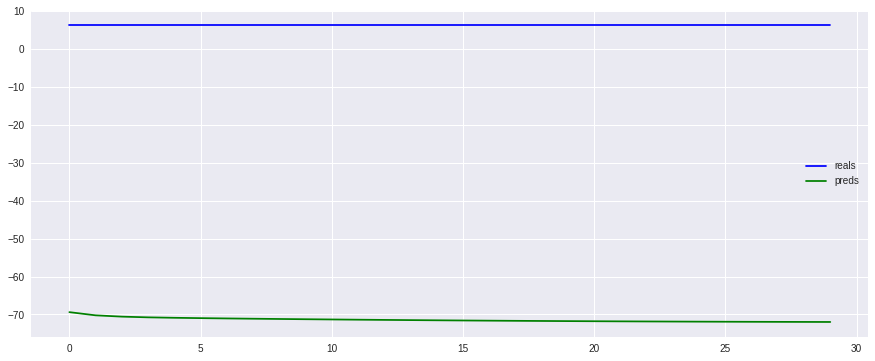

In [48]:
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [49]:
%%time
dtw_scores = [fastdtw(dp.targets[ind], preds_dict[ind])[0]
             for ind in range(len(dp.targets))]

CPU times: user 12.9 s, sys: 108 ms, total: 13 s
Wall time: 12.8 s


In [50]:
np.mean(dtw_scores)

597.57313775922375

In [51]:
coint(preds, reals)

(-0.72379888182376606,
 0.94400853935420637,
 array([-4.31395736, -3.55493606, -3.19393252]))

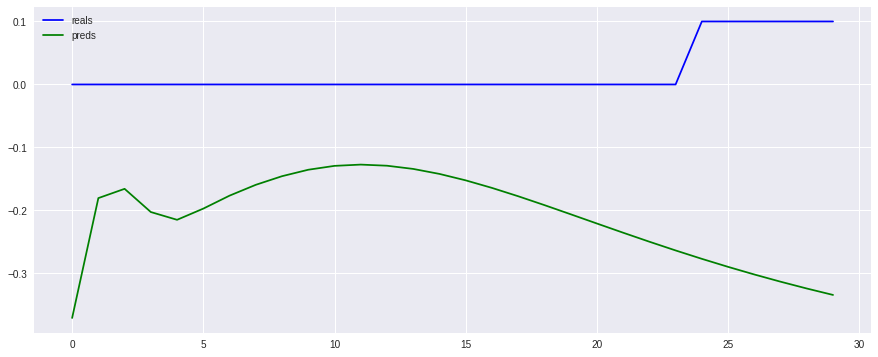

In [70]:
cur_ind = np.random.randint(len(dp.targets))
reals = dp.targets[cur_ind]
preds = preds_dict[cur_ind]
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

#### Conclusion
???